In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
import  mpl_toolkits.basemap
import pyresample
from scipy.interpolate import bisplrep, bisplev

## PLEASE NOTE

It is possible to do these types of interpolations easily and fast with CDO. See Charles Amory for the method.

In [3]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [4]:
path_ju = '/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.'
#path_ian = '/bettik/castelli/data/MAR3.14/MAR-ERA5/EUb/ICE.ERA5.EUb.'
path_ian = '/bettik/castelli/data/MAR3.14/MAR-ERA5/EUc/ICE.ERA5.EUc.'

In [5]:
# Don't take 2014 as it is spin-up year

ds_T_test_v314_2015 = xr.open_dataset(path_ian+'TTz.2015.nc')
ds_T_normal_2015 = xr.open_dataset(path_ju+'TTz.2015.nc')

Tdiff = list()
Tdiff.append(np.array(ds_T_test_v314_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]) - np.array(ds_T_normal_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]))

ds_QQz_test_v314_2015 = xr.open_dataset(path_ian+'QQz.2015.nc')
ds_QQz_normal_2015 = xr.open_dataset(path_ju+'QQz.2015.nc')

QQzdiff = list()
QQzdiff.append(np.array(ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]) - np.array(ds_QQz_normal_2015.QQz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]))

ds_RR_test_v314_2015 = xr.open_dataset(path_ian+'MBrr.2015.nc')
ds_RR_normal_2015 = xr.open_dataset(path_ju+'MBrr.2015.nc')

ds_SF_test_v314_2015 = xr.open_dataset(path_ian+'MBsf.2015.nc')
ds_SF_normal_2015 = xr.open_dataset(path_ju+'MBsf.2015.nc')

# TP : Total Precip

ds_TP_test_v314_2015 = ds_RR_test_v314_2015.MBrr[:,jmin:jmax,imin:imax] + ds_SF_test_v314_2015.MBsf[:,jmin:jmax,imin:imax]
ds_TP_normal_2015 = ds_RR_normal_2015.MBrr[:,jmin:jmax,imin:imax] + ds_SF_normal_2015.MBsf[:,jmin:jmax,imin:imax]

TPdiff = list()
TPdiff.append(np.array(ds_TP_test_v314_2015) - np.array(ds_TP_normal_2015))

In [6]:
ds_TG_EOBS = xr.open_dataset('/bettik/castelli/data/E-OBS/tg_ens_mean_0.1deg_reg_v29.0e.nc')

ds_TG_EOBS_2015 = ds_TG_EOBS.sel(time='2015').isel(latitude=np.arange(170,250,1),longitude=np.arange(280,430,1))
ds_TG_EOBS_2016 = ds_TG_EOBS.sel(time='2016').isel(latitude=np.arange(170,250,1),longitude=np.arange(280,430,1))

ds_TG_EOBS_2015

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 150, time: 365)
Coordinates:
  * latitude   (latitude) float64 42.05 42.15 42.25 42.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 3.05 3.15 3.25 3.35 ... 17.75 17.85 17.95
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Data variables:
    tg         (time, latitude, longitude) float32 ...
Attributes:
    E-OBS_version:  29.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Mar 22 09:55:59 2024: ncks --no-abc -d time,0,27027 /...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

In [7]:
lon_EOBS = np.array(ds_TG_EOBS_2015.longitude)
lat_EOBS = np.array(ds_TG_EOBS_2015.latitude)

#### Change in projection

crs_b = CRS.from_proj4("+proj=stere +lat_0=44.6 +lon_0=7.2 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=km +no_defs")

x, y = monthlyT_test_v314_2015['x'].values, monthlyT_test_v314_2015['y'].values
xx, yy = np.meshgrid(x, y)

lon_b, lat_b = Transformer.from_crs(crs_from=crs_b, crs_to=4326, always_xy=True).transform(xx, yy)

lon_b

## Basemap method (only from regular to curvilinear grid)

http://earthpy.org/interpolation_between_grids_with_basemap.html

In [19]:
test = np.array(ds_TG_EOBS_2015.variables['tg'][0,:,:])
lat_test = np.array(ds_TG_EOBS_2015.variables['latitude'][:])
lon_test = np.array(ds_TG_EOBS_2015.variables['longitude'][:])


result = mpl_toolkits.basemap.interp(test, lon_test, lat_test, lon, lat,
                                     checkbounds=False, masked=False, order=1)

result

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [ 0.1262248 , -0.04179699, -0.33223492, ..., -1.0350263 ,
        -1.7182571 , -2.1019707 ],
       [ 0.08058073, -0.03991712, -0.25293568, ..., -1.5428395 ,
        -1.9336857 , -2.236683  ],
       [ 0.16681743, -0.02560271, -0.39388967, ..., -1.8960195 ,
        -2.0958788 , -2.3027854 ]], dtype=float32)

/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


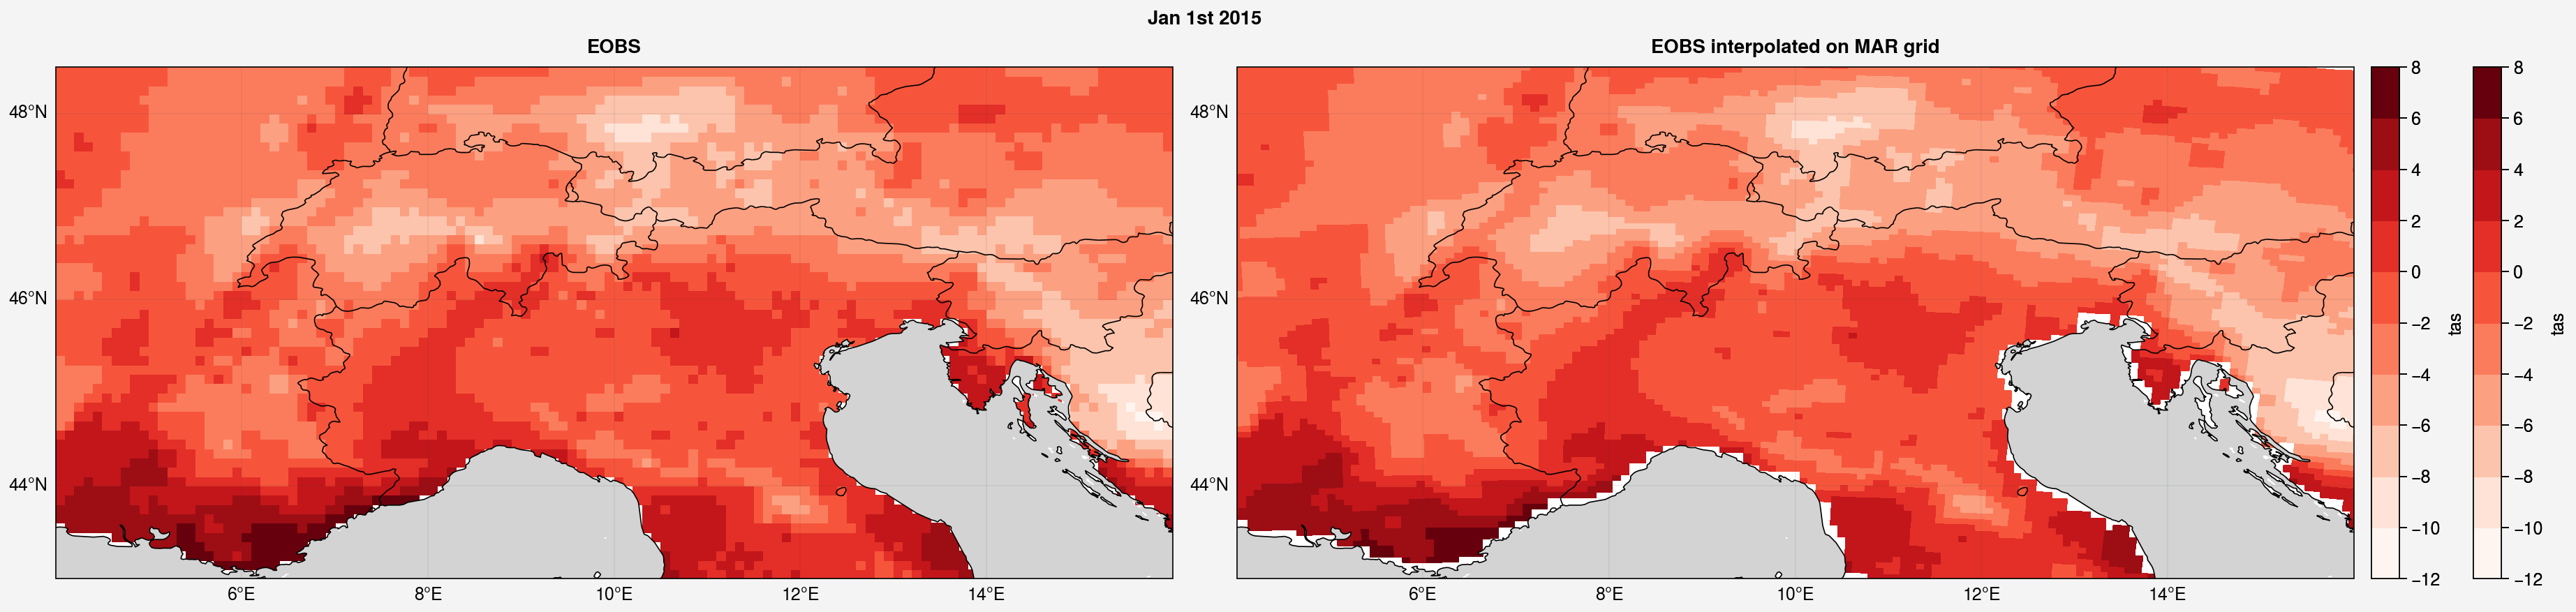

In [63]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon_test, lat_test, test, levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')

m=axs[1].pcolormesh(lon, lat, result, levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')


axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['EOBS','EOBS interpolated on MAR grid'])


In [19]:
def basemap_interp(regular_grid_var,lon_reg,lat_reg,lon_curv,lat_curv): # only from regular grid to curvilinear (lon_reg and lat_reg are 1D, lon_curv and lat_curv are 2D)
    list_interp_var = []

    N = regular_grid_var.shape[0] # example : if regular_grid_var is daily temp for a given year, N should be 365 (or 366 in leap year)
    
    for i in range(N):
        daily_var_reg_grid = np.array(regular_grid_var[i,:,:])
        result = mpl_toolkits.basemap.interp(daily_var_reg_grid, lon_reg, lat_reg, lon_curv, lat_curv,
                                             checkbounds=False, masked=False, order=1)
        list_interp_var.append(result)

    interp_var = np.stack(list_interp_var)
    return interp_var

## With scipy (could work the other way ?)

In [9]:
day=0

In [10]:
x = lon.ravel()
y = lat.ravel()
z = ds_T_test_v314_2015.TTz.isel(ztqlev=0)[day,jmin:jmax,imin:imax].values.ravel()
tck = bisplrep(y, x, z)

x_new = ds_TG_EOBS_2015.longitude.values
y_new = ds_TG_EOBS_2015.latitude.values
z_new = bisplev(y_new, x_new, tck)

cube3 = xr.DataArray(z_new, dims=ds_TG_EOBS_2015.tg[0].dims, coords=ds_TG_EOBS_2015.tg[0].coords)

/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


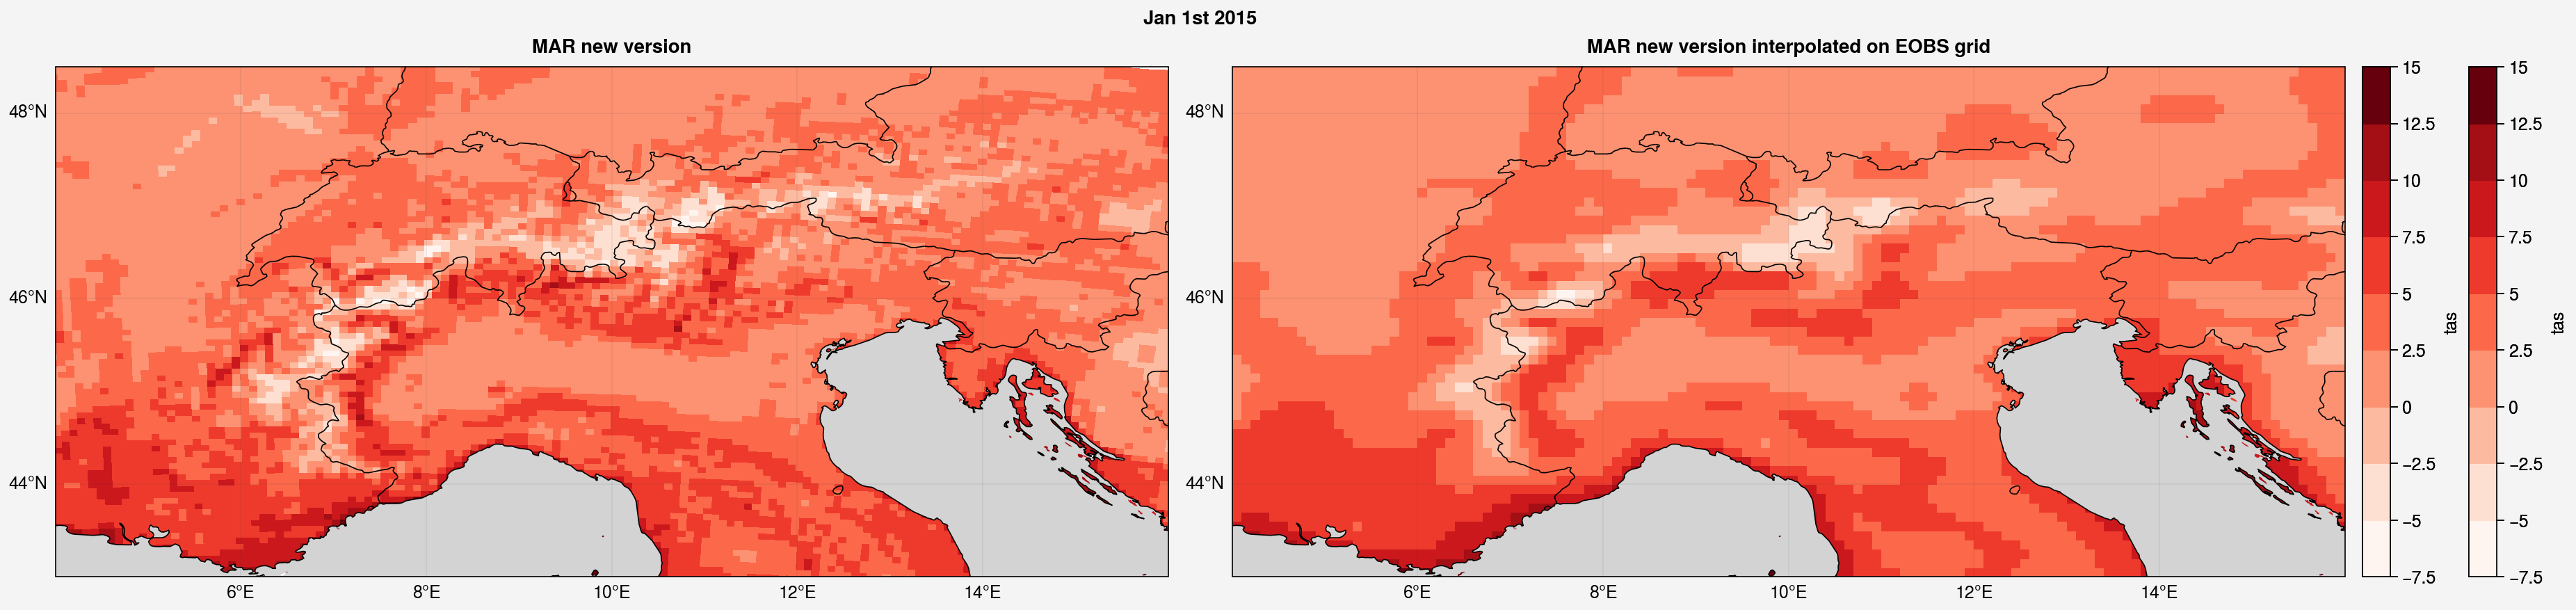

In [13]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon, lat, ds_T_test_v314_2015.TTz.isel(ztqlev=0)[day,jmin:jmax,imin:imax], levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')

m=axs[1].pcolormesh(lon_EOBS, lat_EOBS, cube3, levels=10,cmap='Reds',vmin=-7.5,vmax=15)
f.colorbar(m,label= 'tas')

axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['MAR new version','MAR new version interpolated on EOBS grid'])

In [15]:
# HUMIDITY

x = lon.ravel()
y = lat.ravel()
x_new = ds_TG_EOBS_2015.longitude.values
y_new = ds_TG_EOBS_2015.latitude.values


In [23]:
z = ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[day,jmin:jmax,imin:imax].values.ravel()
tck = bisplrep(y, x, z)
z_new = bisplev(y_new, x_new, tck)

cube3 = xr.DataArray(z_new, dims=ds_TG_EOBS_2015.tg[0].dims, coords=ds_TG_EOBS_2015.tg[0].coords)

/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


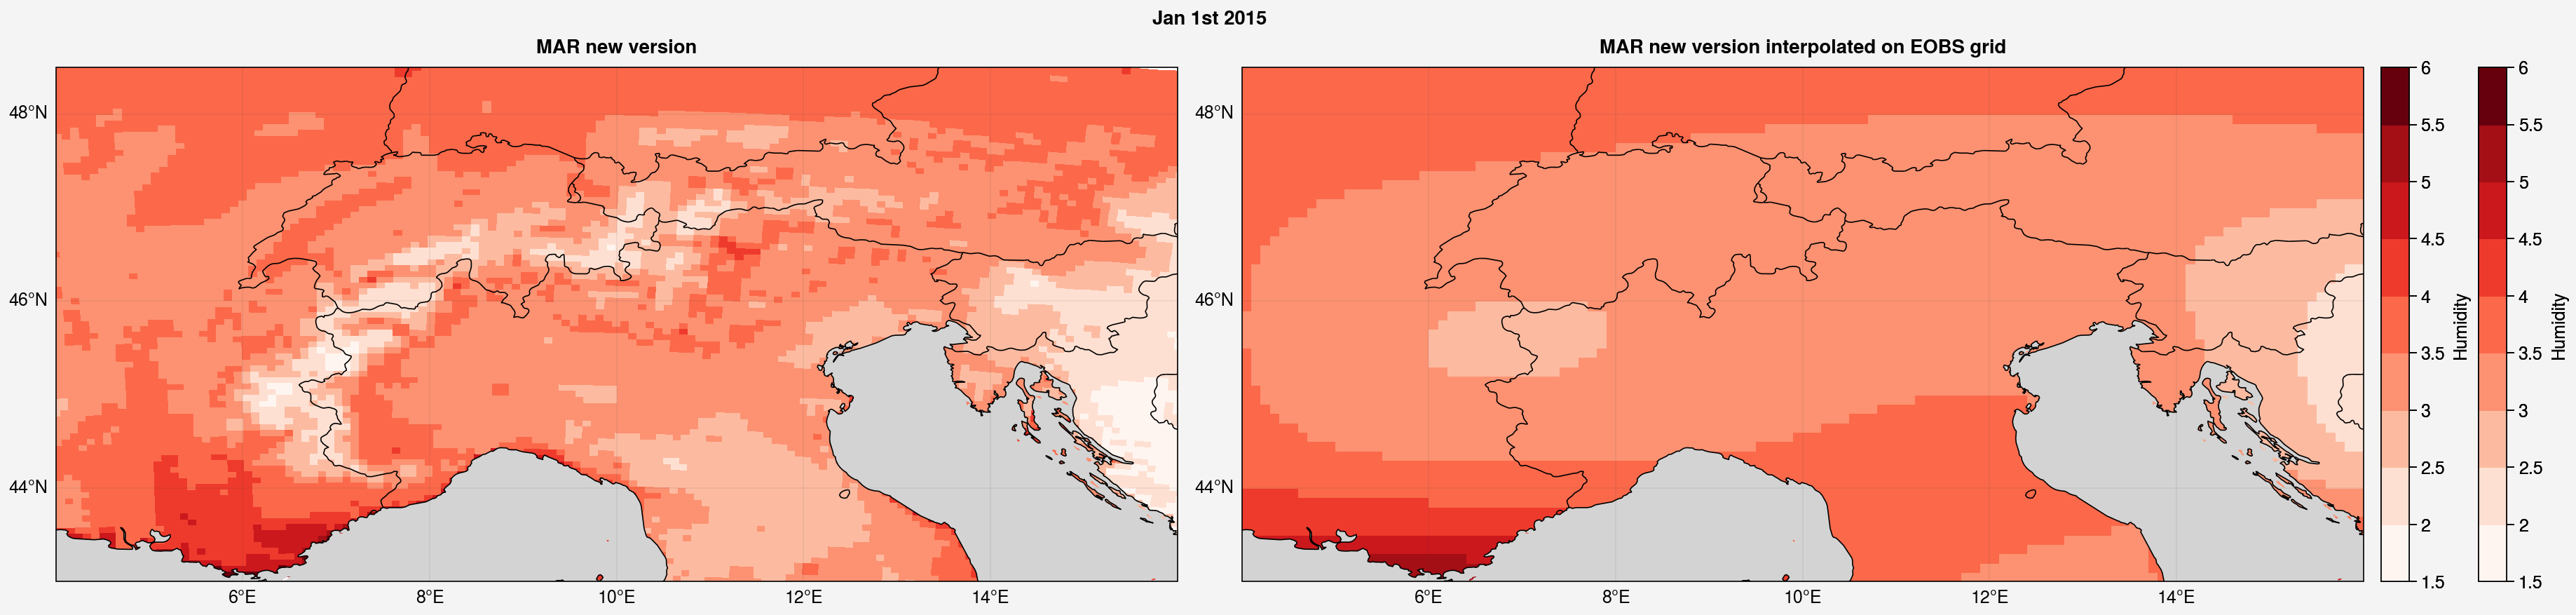

In [24]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon, lat, ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[day,jmin:jmax,imin:imax], levels=10,cmap='Reds')
f.colorbar(m,label= 'Humidity')

m=axs[1].pcolormesh(lon_EOBS, lat_EOBS, cube3, levels=11,cmap='Reds',vmin=1.5,vmax=6)
f.colorbar(m,label= 'Humidity')

axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['MAR new version','MAR new version interpolated on EOBS grid'])

In [16]:
z = ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[day,jmin:jmax,imin:imax].values.ravel()
tck = bisplrep(y, x, z,s=100)
z_new = bisplev(y_new, x_new, tck)

cube3 = xr.DataArray(z_new, dims=ds_TG_EOBS_2015.tg[0].dims, coords=ds_TG_EOBS_2015.tg[0].coords)

/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


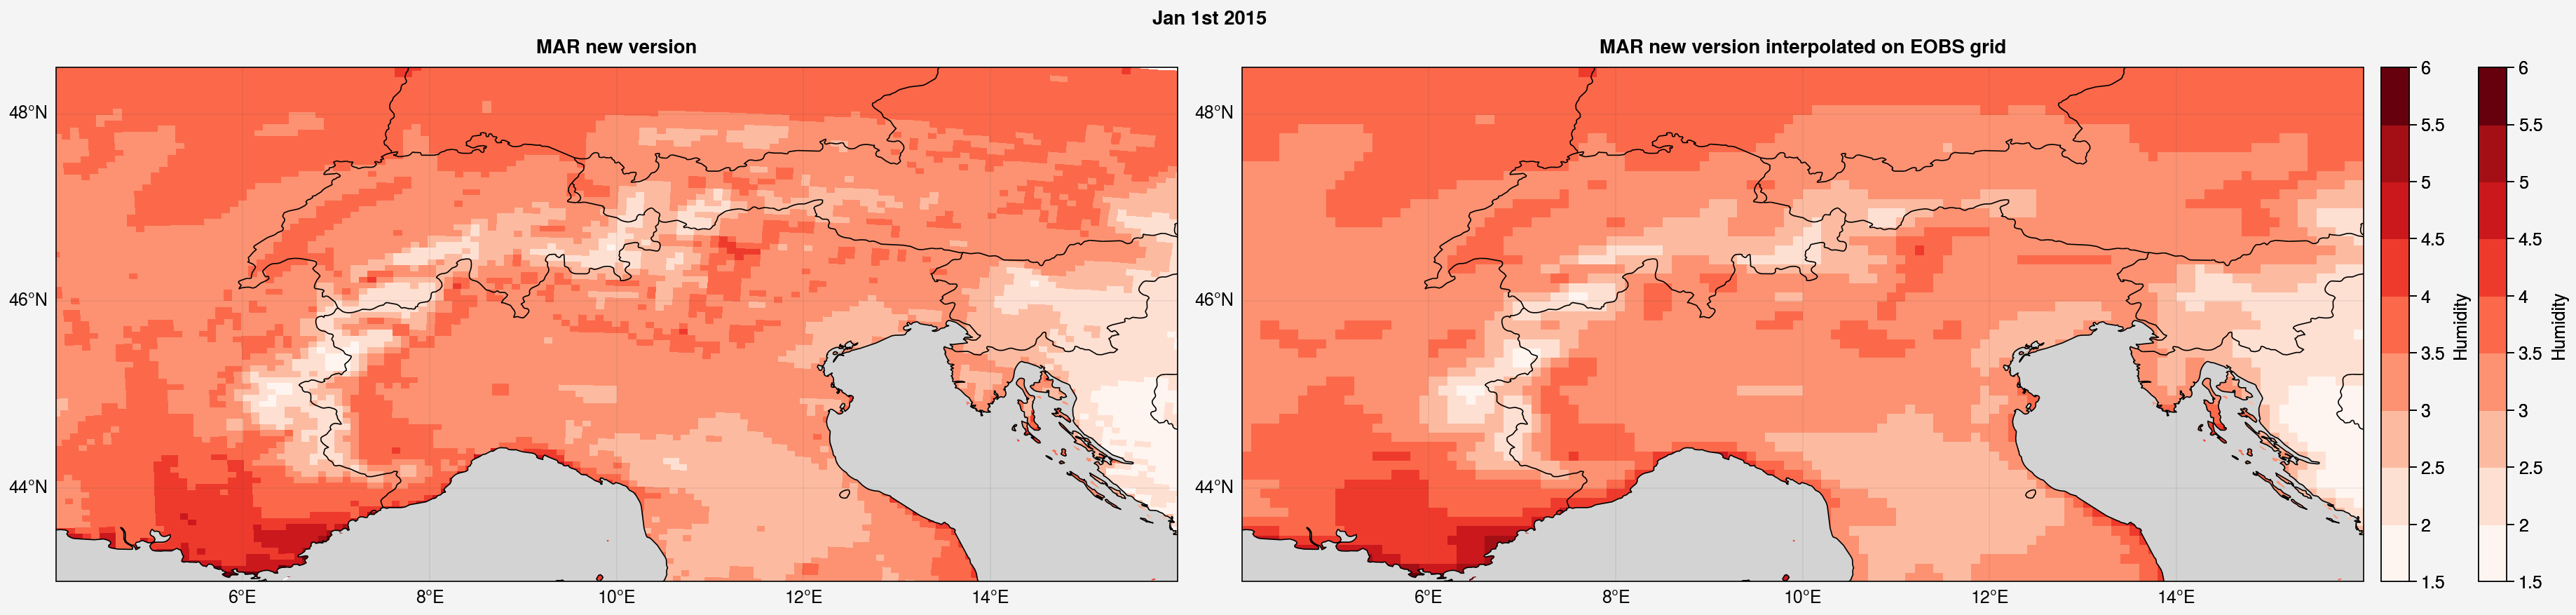

In [20]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon, lat, ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[day,jmin:jmax,imin:imax], levels=10,cmap='Reds')
f.colorbar(m,label= 'Humidity')

m=axs[1].pcolormesh(lon_EOBS, lat_EOBS, cube3, levels=11,cmap='Reds',vmin=1.5,vmax=6)
f.colorbar(m,label= 'Humidity')

axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['MAR new version','MAR new version interpolated on EOBS grid'])

In [26]:
z = ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[day,jmin:jmax,imin:imax].values.ravel()
tck = bisplrep(y, x, z,s=200)
z_new = bisplev(y_new, x_new, tck)

cube3 = xr.DataArray(z_new, dims=ds_TG_EOBS_2015.tg[0].dims, coords=ds_TG_EOBS_2015.tg[0].coords)

/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v2/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


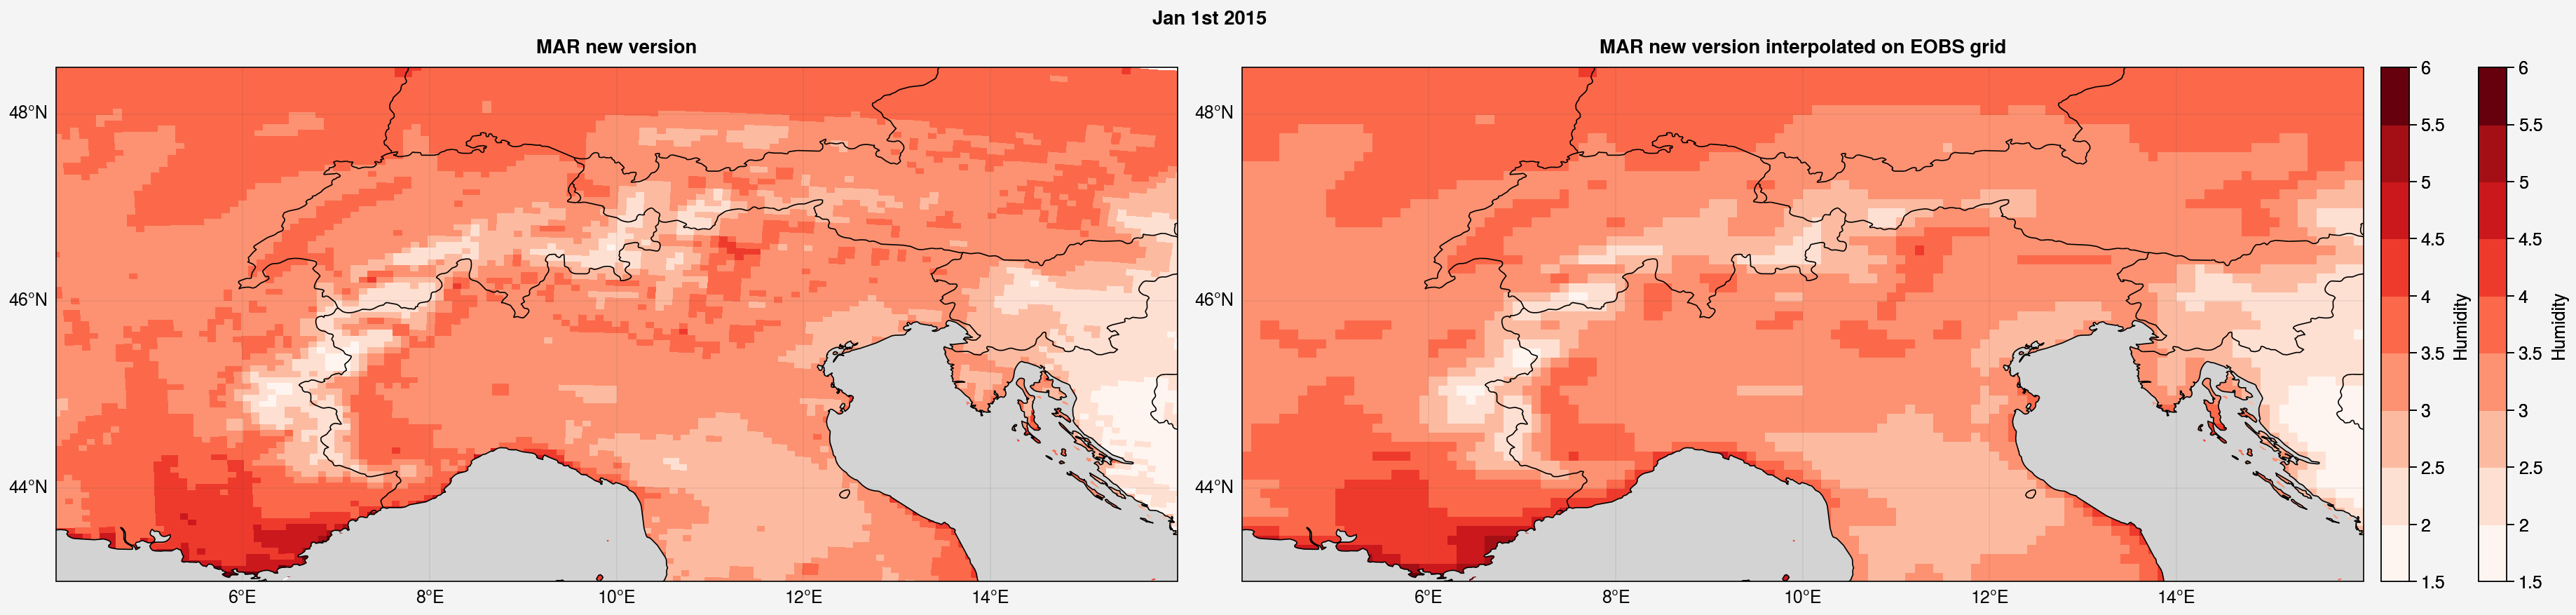

In [27]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon, lat, ds_QQz_test_v314_2015.QQz.isel(ztqlev=0)[day,jmin:jmax,imin:imax], levels=10,cmap='Reds')
f.colorbar(m,label= 'Humidity')

m=axs[1].pcolormesh(lon_EOBS, lat_EOBS, cube3, levels=11,cmap='Reds',vmin=1.5,vmax=6)
f.colorbar(m,label= 'Humidity')

axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['MAR new version','MAR new version interpolated on EOBS grid'])

In [20]:
def scipy_interp(curv_grid_var,lon_curv,lat_curv,lon_reg,lat_reg):  # here from curvilinear to regular grid
    list_interp_var = []

    N = curv_grid_var.shape[0] # example : if regular_grid_var is daily temp for a given year, N should be 365 (or 366 in leap year)
    x = lon_curv.ravel()
    y = lat_curv.ravel()
    x_new = lon_reg
    y_new = lat_reg
    for i in range(N):
        print(i,end=' ')
        #z = curv_grid_var[i].values.ravel()
        z = curv_grid_var[i].ravel()
        tck = bisplrep(y, x, z, s=500)
        #print('bisplrep done',end=' ')
        z_new = bisplev(y_new, x_new, tck)
        #print('bisplev done',end=' ')
        list_interp_var.append(z_new)
    
    interp_var = np.stack(list_interp_var)
    return interp_var

## With xESMF - Best way

In [8]:
# Using Mickael Lalande's function in utils, otherwise just use regridder from xesmf

#test = ds_T_test_v314_2015.TTz.isel(ztqlev=0).isel(time=0)[jmin:jmax,imin:imax]
test = ds_T_test_v314_2015.TTz.isel(ztqlev=0)[:,jmin:jmax,imin:imax]

# MAR has a very slight difference in x and y positions of grid cells between MARgrid and the simulations, which will prevent the regridding. So have to do this :
lon_correct_xy = ds.LON[jmin:jmax,imin:imax] # copy the incorrect lon/lat
lat_correct_xy = ds.LAT[jmin:jmax,imin:imax]

lon_correct_xy["x"] = ("x", test.x.values) # correct lon
lon_correct_xy["y"] = ("y", test.y.values)

lat_correct_xy["x"] = ("x", test.x.values) # correct lat
lat_correct_xy["y"] = ("y", test.y.values)

test.coords['lon'] = lon_correct_xy
test.coords['lat'] = lat_correct_xy

test_regrid = u.regrid(test,ds_TG_EOBS_2015,'bilinear',globe=True,periodic=False,reuse_weights=False) # globe=False gives an error, because of scipy.sparse.csr_matrix(X)
                                                                                                                # in add_matrix_NaNs
test_regrid

<xarray.DataArray (time: 365, latitude: 80, longitude: 150)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
    ztqlev     float32 2.0
  * latitude   (latitude) float64 42.05 42.15 42.25 42.35 ... 49.75 49.85 49.95
  * longitude  (longitude) float64 3.05 3.15 3.25 3.35 ... 17.75 17.85 17.95
Attributes:
    regrid_method:  bilinear
    units:          C
    long_name:      Temperature
    standard_name:  Temperature
    actual_range:   [-20.691431  20.232143]
    cell_methods:   time: mean

In [9]:
test

<xarray.DataArray 'TTz' (time: 365, y: 91, x: 139)>
array([[[ 9.214099,  9.306477, ...,  8.027635,  7.924051],
        [ 9.037285,  9.118703, ...,  7.991868,  7.832749],
        ...,
        [-0.032535,  0.339872, ..., -2.329796, -2.629418],
        [-0.238095,  0.266634, ..., -2.168661, -2.447447]],

       [[11.961897, 12.11707 , ..., 12.562517, 12.596089],
        [11.863504, 12.069141, ..., 12.577668, 12.601375],
        ...,
        [ 2.23749 ,  2.470863, ...,  3.166391,  2.520758],
        [ 2.303823,  2.548503, ...,  3.327955,  2.823113]],

       ...,

       [[13.655927, 13.676003, ..., 12.068644, 11.933764],
        [13.629679, 13.656385, ..., 11.997559, 11.87512 ],
        ...,
        [ 6.46274 ,  6.623821, ...,  0.514162,  0.542313],
        [ 6.14258 ,  6.303067, ...,  0.448407,  0.484608]],

       [[13.863091, 13.913135, ...,  9.326861,  9.285624],
        [13.884362, 13.934706, ...,  9.291603,  9.253032],
        ...,
        [ 8.326447,  8.285563, ..., -3.827857, -3.787593],
        [ 8.095393,  8.20113 , ..., -3.95102 , -3.839536]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2015-12-31T12:00:00
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
    ztqlev   float32 2.0
    lon      (y, x) float32 4.013 4.099 4.185 4.271 ... 16.49 16.59 16.68 16.77
    lat      (y, x) float32 43.04 43.05 43.05 43.05 ... 48.39 48.38 48.37 48.37
Attributes:
    units:          C
    long_name:      Temperature
    standard_name:  Temperature
    actual_range:   [-20.691431  20.232143]
    cell_methods:   time: mean

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


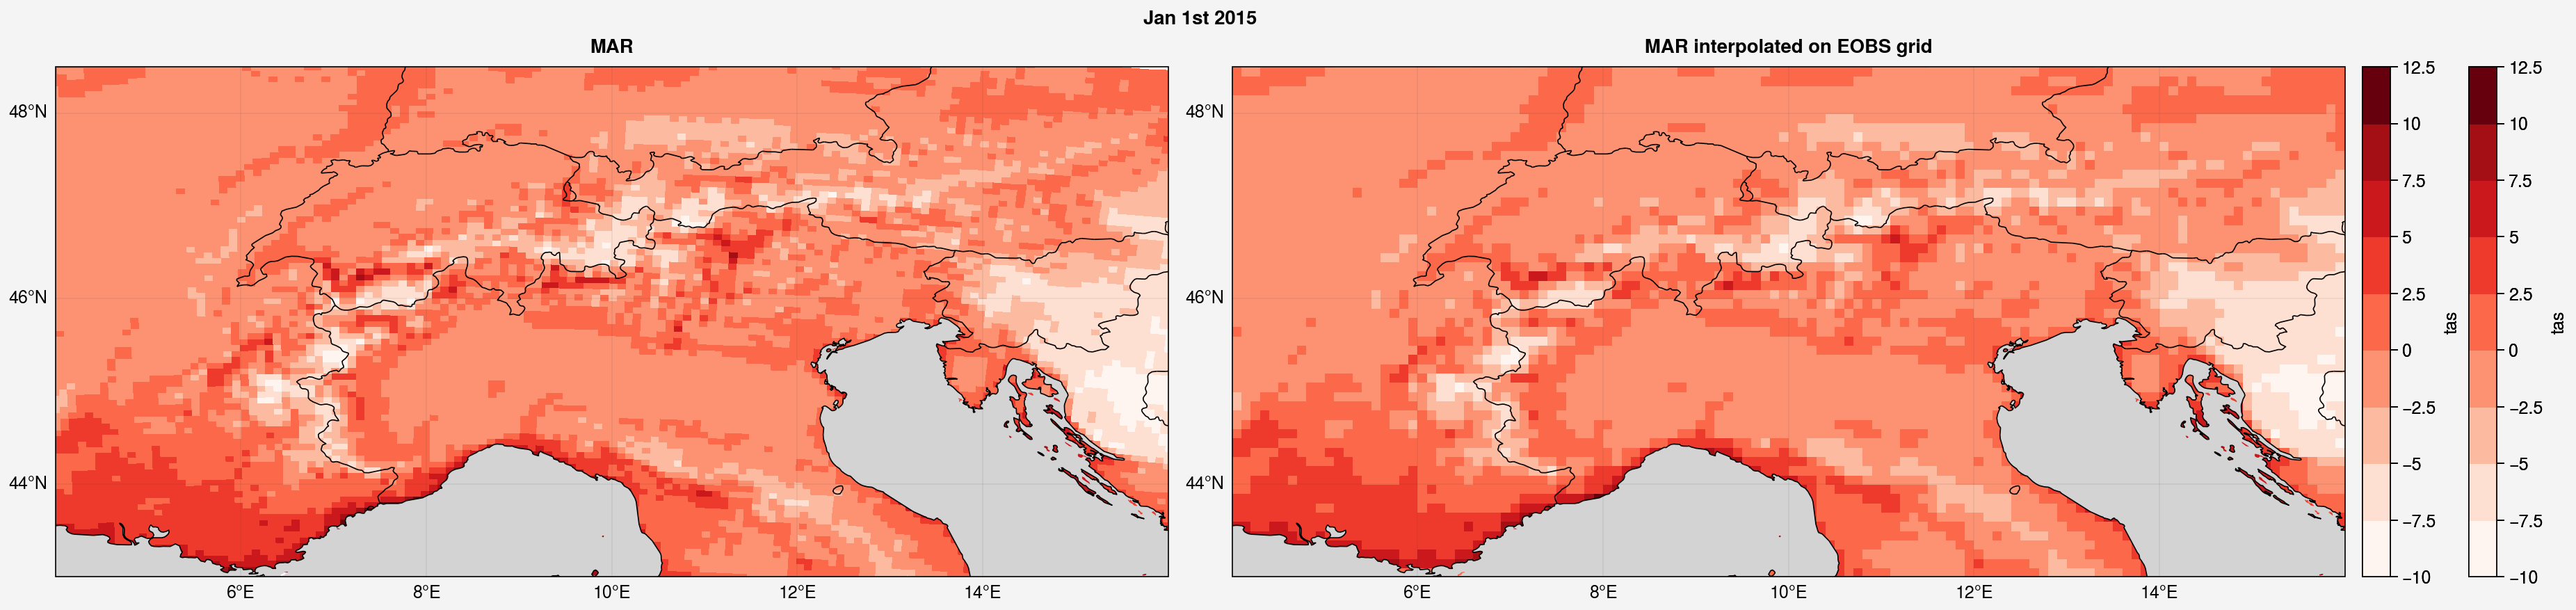

In [21]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon, lat, test[0], levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')

m=axs[1].pcolormesh(lon_EOBS, lat_EOBS, test_regrid[0], levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')


axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['MAR','MAR interpolated on EOBS grid'])

In [22]:
testEOBS_regrid = u.regrid(ds_TG_EOBS_2015,test,'bilinear',globe=True,periodic=False,reuse_weights=False)

testEOBS_regrid

<xarray.Dataset>
Dimensions:  (time: 365, y: 91, x: 139)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
    ztqlev   float32 2.0
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
    lat      (y, x) float32 43.04 43.05 43.05 43.05 ... 48.39 48.38 48.37 48.37
    lon      (y, x) float32 4.013 4.099 4.185 4.271 ... 16.49 16.59 16.68 16.77
Data variables:
    tg       (time, y, x) float32 nan nan nan nan ... -2.878 -2.71 -2.636 -2.61
Attributes:
    regrid_method:  bilinear
    E-OBS_version:  29.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Mar 22 09:55:59 2024: ncks --no-abc -d time,0,27027 /...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


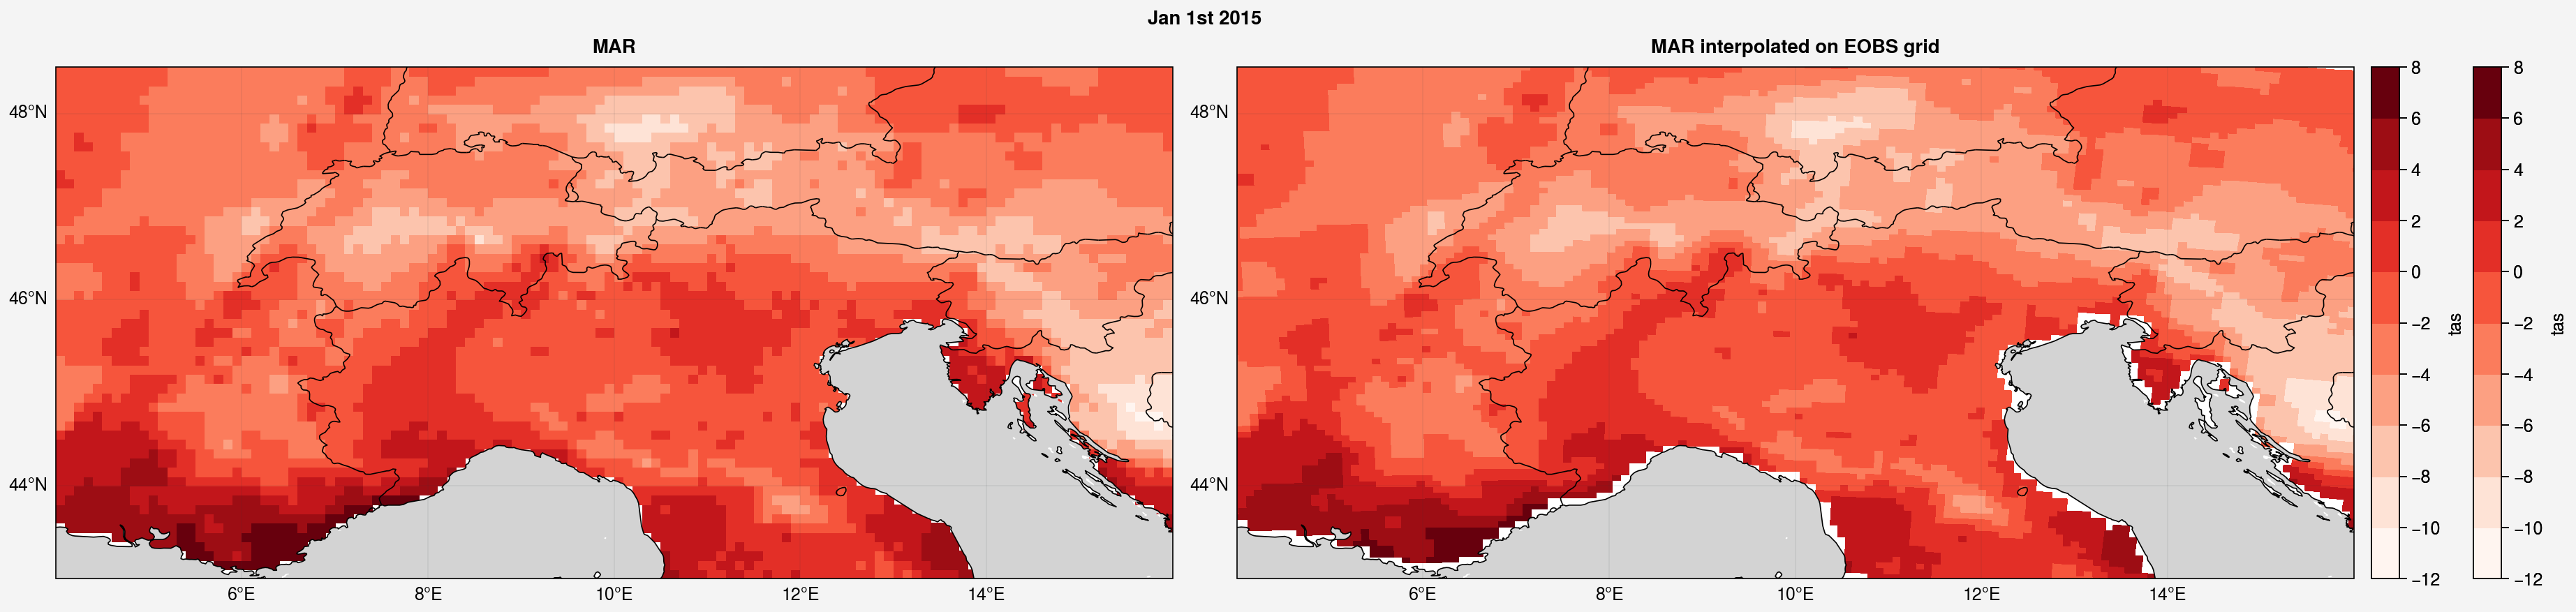

In [25]:
f, axs = pplt.subplots(proj='cyl', axwidth=8,ncols=2)

m=axs[0].pcolormesh(lon_EOBS, lat_EOBS, ds_TG_EOBS_2015.tg[0], levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')

m=axs[1].pcolormesh(lon, lat, testEOBS_regrid.tg[0], levels=10,cmap='Reds')
f.colorbar(m,label= 'tas')


axs.format(**normal_format)
axs.format(ocean=True,oceancolor='lightgray',reso='hi',suptitle='Jan 1st 2015',collabels=['MAR','MAR interpolated on EOBS grid'])

In [16]:
test

<xarray.DataArray 'TTz' (y: 91, x: 139)>
array([[ 9.214099,  9.306477,  9.371682, ...,  8.191158,  8.027635,  7.924051],
       [ 9.037285,  9.118703,  9.179346, ...,  8.164866,  7.991868,  7.832749],
       [ 8.883946,  8.930471,  8.951121, ...,  8.15939 ,  7.911797,  7.680718],
       ...,
       [ 0.286575,  0.289769,  0.305173, ..., -1.812675, -2.198346, -2.616107],
       [-0.032535,  0.339872,  0.312422, ..., -1.976096, -2.329796, -2.629418],
       [-0.238095,  0.266634,  0.250643, ..., -1.779193, -2.168661, -2.447447]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-01-01T12:00:00
  * x        (x) float32 -259.0 -252.0 -245.0 -238.0 ... 686.0 693.0 700.0 707.0
  * y        (y) float32 -168.0 -161.0 -154.0 -147.0 ... 441.0 448.0 455.0 462.0
    ztqlev   float32 2.0
    lon      (y, x) float32 4.013 4.099 4.185 4.271 ... 16.49 16.59 16.68 16.77
    lat      (y, x) float32 43.04 43.05 43.05 43.05 ... 48.39 48.38 48.37 48.37
Attributes:
    units:          C
    long_name:      Temperature
    standard_name:  Temperature
    actual_range:   [-20.691431  20.232143]
    cell_methods:   time: mean